In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Lab 9 - Multi-layer Perceptron Forward Pass & Backpropagation

## Part I
For this exercise you will implement a simple 2-layer perceptron with the forward pass and the backpropagation to learn the weights

For the first part you'll build and train a 2-layer neural network that predicts the prices of houses, using the usual Boston housing dataset.

In [6]:
boston = pd.read_csv('BostonHousing.txt')
print(boston.shape)
boston.head()

(506, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


As usual, consider the MEDV as your target variable. 
* Split the data into training, validation and testing (70,15,15)%
* Experiment with different number of neurons per layer for your network, using the validation set

In [11]:
# your code goes here
x, t = boston.values[:, :-1], boston.values[:, -1]
t = t.reshape(-1,1)

x_train, x_temp, t_train, t_temp = train_test_split(x, t, train_size = 0.7)
x_valid, x_test, t_valid, t_test = train_test_split(x_temp, t_temp, train_size = 0.5)

In [4]:
# Most common activation functions
def id_activation(z):
    return z

def id_derivative(z):
    return 1

def sigmoid_activation(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    sig = sigmoid_activation(z)
    return  sig*(1-sig)

def softmax_activation(z: np.ndarray):
    return np.exp(z)/(np.sum(np.exp(z), axis=1)).reshape(-1,1)

def softmax_derivative(z):
    soft = softmax_activation(z)
    return soft * (1-soft)

# Error functions
def SSE(predict, target):
    return np.sum((predict - target)**2)

def SSE_derivative(predict, target):
    return predict - target

def RMSE(predict, target):
    return np.sqrt(np.mean((predict - target)**2))

def Cross_Entropy(predict, target):
    return -(np.sum(target * np.log(predict) + (1-target)*np.log(1-predict)))

def CE_derivative(predict, target):
    return (target/predict) + (1 - target)/(1 - predict)

def CE_multiclass(predict, target):
    return -np.sum(target * np.log(predict))

In [5]:
# Multi-Layer Perceptron
class MultiLayer_Perceptron():
    def __init__(self, model: int, regularization: float = 0) -> None:
        """Initiating the class, you must decide wich type of model will be trained

        :param model: An enumeration of the type of model:
            - 0 = Regression Model
            - 1 = Binary Classification
            - 2 = Multiple Non-Exclusive Classification
            - 3 = Multiple Mutualy Exclusive Classification
        
        :type model: int
        
        :param regularization: The value of lambda to be used in the quadratic error regularization
        :type regularization: float, defaults to 0
        """
        self.features = ((sigmoid_activation, sigmoid_derivative, id_activation, SSE, SSE_derivative), 
                         (sigmoid_activation, sigmoid_derivative, sigmoid_activation, Cross_Entropy, CE_derivative), 
                         (sigmoid_activation, sigmoid_derivative, sigmoid_activation, Cross_Entropy, CE_derivative), 
                         (sigmoid_activation, sigmoid_derivative, softmax_activation, CE_multiclass, SSE_derivative))
        # Defining some important functions according to the wished model
        self.model = model

        self.activation_func = self.features[model][0]
        self.derivative_func = self.features[model][1]

        self.output_func = self.features[model][2]

        self.error_func = self.features[model][3]
        self.error_derivative = self.features[model][4]

        self.weights = None
        
        self.reg_lambda = regularization # Lambda value to use in the regularization

    def forward_pass(self, x: np.ndarray, apply_bias: bool = False) -> tuple[np.ndarray | float, list, list]:
        """
        Implements the forward pass of a multi-layer fully connected perceptron.
        
        Parameters
        ----------
        x : a 2-dimensional array
            the input data
        apply_bias : bool, defaults to False
            if True, apply bias to the input data. For independent use purposes
        
        Returns
        -------
        y_pred : np.ndarray
            the output of the computation of the forward pass of the network
        a_list : list
            list with every layer's input matrices
        z_list : list
            list with every layer's output matrices
        """
        if apply_bias:
            x = np.insert(x, 0, 1, axis=1)
        
        # If we have only one weight matrix, we have no layers, just a simple prediction
        if len(self.weights) == 1:
            return self.output_func(x @ self.weights[-1])

        # Using forward propagation
        a_list = []
        z_list = []

        # Input layer:
        a = x @ self.weights[0]
        a_list.append(a)

        z = self.activation_func(a)
        z = np.insert(z, 0, 1, axis = 1)
        z_list.append(z)

        # Hidden layers: 
        for i in range(1, len(self.weights)-1):
            a = z @ self.weights[i] # First step of unit
            a_list.append(a)

            z = self.activation_func(a) # Second step of unit
            z = np.insert(z, 0, 1, axis = 1) # Preparing z for next bias
            z_list.append(z)

        # Last Hidden Layer (output):
        y_pred = self.output_func(z @ self.weights[-1])
        return y_pred, a_list, z_list

    def __backpropagation__(self, x: np.ndarray, target: np.ndarray, prediction: np.ndarray, a_list: list[np.ndarray], z_list: list[np.ndarray]):
        """Adjust the weight matrices in the 'weights' list, accordding to the error propagated from the dataset 'x', the prediction, and the target.
        This auxiliar method will alter the weights in-place, and won't return anything.

        :param x: Dataset used to train the model.
        :type x: np.ndarray

        :param target: Target of the prediction.
        :type target: np.ndarray

        :param prediction: Predicted values.
        :type prediction: np.ndarray

        :param a_list: List with each unit's input values.
        :type a_list: list[np.ndarray]

        :param z_list: List with each unit's output values.
        :type z_list: list[np.ndarray]
        """
        a_list.reverse()
        z_list.reverse()
        self.weights.reverse() 
        # Now, we're dealing with the reversed weights and parameters, so we're starting from the output layer

        # Updating the output layer
        w = self.weights[0]
        z = z_list[0]

        deltas_next = self.error_derivative(prediction, target)

        d_error = z.T @ deltas_next
        reg_error = d_error + (self.reg_lambda * np.sum(w)) # Regularizing the error
        
        w = w - (0.01 * reg_error) # Adjusting weights
        self.weights[0] = w

        # Updating the middle layers
        for layer in range(1, len(self.weights) - 1):
            w = self.weights[layer]
            a = a_list[layer]
            z = z_list[layer]

            # Finding the layer's deltas
            deltas = self.derivative_func(a) * (self.weights[layer-1][1:,:] @ deltas_next.T).T
            
            d_error = z.T @ deltas
            reg_error = d_error + (self.reg_lambda * np.sum(w)) # Regularizing the error

            w = w - (0.01 * reg_error) # Adjusting weights

            deltas_next = deltas
            self.weights[layer] = w

        # Finally, updating the input weights
        w = self.weights[-1]

        deltas = self.derivative_func(x @ w) * (self.weights[-2][1:,:] @ deltas_next.T).T

        d_error = x.T @ deltas
        reg_error = d_error + (self.reg_lambda * np.sum(w)) # Regularizing the error

        w = w - (0.01 * reg_error) # Adjusting weights
        self.weights[-1] = w

        self.weights.reverse() # Reverts w back to normal
        return

    def __generate_random_weights__(self, x, target, neuron_num, layer_num):
        """This auxiliar function generates random weight matrices according to the passed parameters, and updates them in-place.

        :param x: 2-dimensional array with training data. Each line must be a datapoint. Defines the first dimension of the input weight matrix. 
        :type x: np.ndarray

        :param target: 2-dimensional array with targets to the training data. Each line must refer to a datapoint. Defines the second dimension of the output weight matrix.
        :type target: np.ndarray
        
        :param neuron_num: Number of neurons to use in each hidden layer. Will define the shapes of most weight matrices.
        :type neuron_num: int
        
        :param layer_num: Number of hidden layers to use in the neural network. Will define the amount of weight matrices.
        :type layer_num: int
        """
        w = []
        rng = np.random.default_rng()
        
        # Creating input weights
        w.append(rng.normal(0, 0.01, (x.shape[1], neuron_num)))

        # Creating middle layers weights
        for i in range(1, layer_num):
            w.append(rng.normal(0, 0.01, (neuron_num + 1, neuron_num)))

        # Creating output weights
        w.append(rng.normal(0, 0.01, (neuron_num + 1, target.shape[1])))

        self.weights = w
        return

    def fit(self, x: np.ndarray, target: np.ndarray, 
            layer_num: int, neuron_num: int, epochs_num: int, 
            validation: tuple[np.ndarray, np.ndarray] = None, gradient_descent: int = 0, apply_bias: bool = True):
        """Trains the model through multilayer perceptron neural network.

        :param x: 2-dimensional array with training data. Each line must be a datapoint. 
        :type x: np.ndarray

        :param target: 2-dimensional array with targets to the training data. Each line must refer to a datapoint.
        :type target: np.ndarray
        
        :param layer_num: Number of hidden layers to use in the neural network.
        :type layer_num: int
        
        :param neuron_num: Number of neurons to use in each hidden layer. All layers will have the same amount of neurons.
        :type neuron_num: int
        
        :param epochs_num: Amount of repetitions to train the weights through the stochastic gradient descent. 
            BE CAREFUL! If using stochastic gradient descent, it's not recommended to use too many epochs.
        :type epochs_num: int

        :param validation: Must be a tuple. The first element being the validation set. The second one being the target set.
        If passed, will calculate the validation loss along with the training, and return it in the loss list.
        :type validation: tuple[np.ndarray, np.ndarray | float], defaults to None

        :param gradient_descent: enumeration that defines wich method of gradient descent to use
            - 0 = Stochastic
            - 1 = Batch
        :type gradient_descent: int, defaults to 0

        :param apply_bias: if True, apply a 'ones' column at the beggining of the data array
        :type apply_bias: bool, defaults to True

        ---

        :return loss: Returns a list with three lists: one with range(epochs_num), one with the training loss, and (if passed) one with the validation loss
        :rtype loss: list[list, list, list]
        """
        # First we apply the bias in the raw data
        if apply_bias:
            x = np.insert(x, 0, 1, axis=1)

        self.__generate_random_weights__(x, target, neuron_num, layer_num)

        # Now, we must train the data through forward pass, gradient descent and backpropagation
        loss = [list(range(epochs_num)), [], []]

        if gradient_descent == 0:
            # Stochastic Gradient Descent
            for epoch in range(epochs_num):
                for i in range(x.shape[0]):
                    datapoint = x[i].reshape(1,-1) # Reshaping it to be a 2-dimensional line vector
                    target_point = target[i].reshape(1,-1)

                    y_pred, a_list, z_list = self.forward_pass(datapoint) # Calling the forward pass to a single datapoint

                    self.__backpropagation__(datapoint, target_point, y_pred, a_list, z_list) # Updating w with backpropagation
                    
                y_pred = self.forward_pass(x)[0]
                if self.model == 0:
                    loss[1].append(RMSE(y_pred, target)) # At the end of each epoch, we calculate the error
                else:    
                    loss[1].append(self.error_func(y_pred, target)) # At the end of each epoch, we calculate the error
                
                if validation:
                    val_pred = self.forward_pass(validation[0], True)[0]
                    if self.model == 0:
                        loss[2].append(RMSE(val_pred, validation[1]))
                    else:    
                        loss[2].append(self.error_func(val_pred, validation[1]))

            return loss
        
        elif gradient_descent == 1:
            # Batch Gradient Descent
            for epoch in range(epochs_num):
                y_pred, a_list, z_list = self.forward_pass(x)

                self.__backpropagation__(x, target, y_pred, a_list, z_list) # Updating w with backpropagation
                    
                loss[1].append(self.error_func(y_pred, target)) # At the end of each epoch, we calculate the error
                
                if validation:
                    val_pred = self.forward_pass(validation[0], True)[0]
                    loss[2].append(self.error_func(val_pred, validation[1]))

            return loss


In [34]:
# your code goes here
reg = MultiLayer_Perceptron(0, 0.0001)

data = []

for neurons in range(50):
    loss0 = reg.fit(x_train, t_train, 2, neurons, 50)[1][-1]
    data.append(loss0)

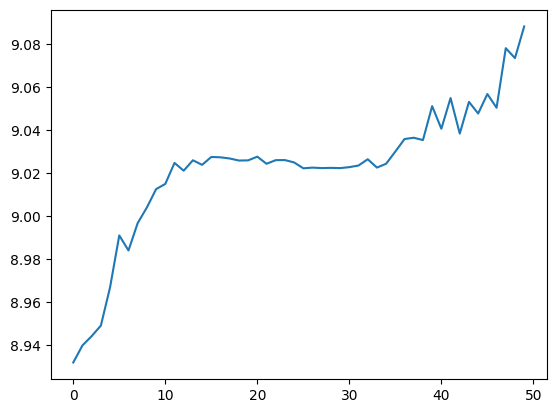

In [35]:
plt.plot(data)
plt.show()

As we can see, small numbers of neurons are better, so let's stick with only 3

In [49]:
x_final = np.vstack((x_train, x_valid))
t_final = np.vstack((t_train, t_valid))

final_reg = MultiLayer_Perceptron(0, 0.0001)
final_reg.fit(x_final, t_final, 1, 3, 50)

# Making the prediction with the testing data
prediction = final_reg.forward_pass(x_test, True)[0] 
final_error = RMSE(prediction, t_test)
print("Final training error:", final_error)

Final training error: 0.25500112007971576


## Part II 

For this exercise you will build and train a 2-layer neural network that predicts the exact digit from a hand-written image, using the MNIST dataset. 
For this exercise, add weight decay to your network.

In [36]:
from sklearn.datasets import load_digits

In [37]:
digits = load_digits()

In [38]:
X = digits.data
y = digits.target

In [40]:
y.shape

(1797,)

In [44]:
y[:5]

array([0, 1, 2, 3, 4])

Again, you will split the data into training, validation and testing.

In [46]:
# First I need to turn y into a probability vector
t = np.zeros((y.shape[0], 10))
for i in range(t.shape[0]):
    t[i, y[i]] = 1

t[:5,:]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [53]:
x_train, x_temp, t_train, t_temp = train_test_split(X, t, train_size = 0.7)
x_valid, x_test, t_valid, t_test = train_test_split(x_temp, t_temp, train_size = 0.5)

C:\Users\georg\AppData\Local\Temp\ipykernel_13780\95304115.py:131: RuntimeWarning: overflow encountered in matmul
  deltas = self.derivative_func(a) * (self.weights[layer-1][1:,:] @ deltas_next.T).T
C:\Users\georg\AppData\Local\Temp\ipykernel_13780\95304115.py:131: RuntimeWarning: invalid value encountered in multiply
  deltas = self.derivative_func(a) * (self.weights[layer-1][1:,:] @ deltas_next.T).T


<Axes: title={'center': 'Validation Loss'}, xlabel='Epochs', ylabel='SSE'>

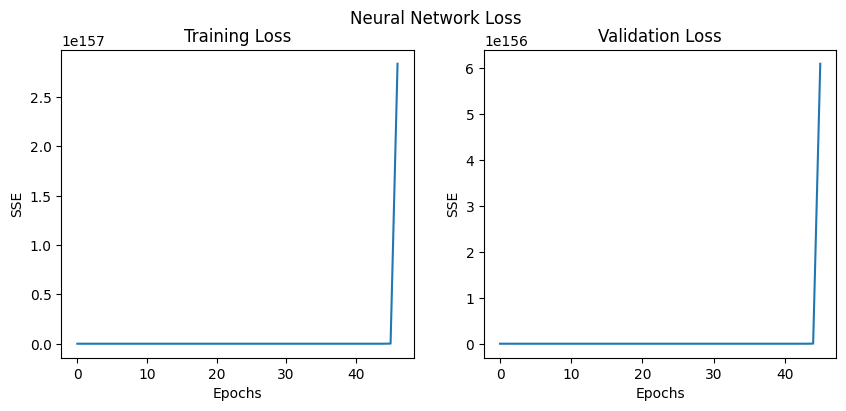

In [52]:
# your code goes here:
classification = MultiLayer_Perceptron(0, 0.1)
test_loss = classification.fit(x_train, t_train, 3, 3, 1000, (x_valid, t_valid), 1)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle("Neural Network Loss")

axes[0].set_title("Training Loss")
axes[1].set_title("Validation Loss")

sns.lineplot({"Epochs": test_loss[0], "SSE": test_loss[1]}, x="Epochs", y="SSE", ax=axes[0])
sns.lineplot({"Epochs": test_loss[0], "SSE": test_loss[2]}, x="Epochs", y="SSE", ax=axes[1])
# The plots are in different scales since we use SSE, wich does not normalizes the error, and our training data is far bigger than the validation 

In [57]:
classif = MultiLayer_Perceptron(3, 0.001)

data = []

for neurons in range(10, 201, 10):
    loss0 = classif.fit(x_train, t_train, 2, neurons, 50)[1][-1]
    data.append(loss0)

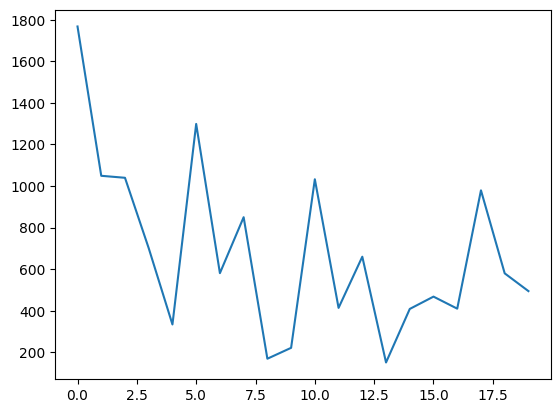

In [58]:
plt.plot(data)
plt.show()

In [62]:
np.argmin(data)

13

In [63]:
neurons = range(10, 201, 10)[13]

x_final = np.vstack((x_train, x_valid))
t_final = np.vstack((t_train, t_valid))

final_class = MultiLayer_Perceptron(3, 0.001)
final_class.fit(x_final, t_final, 1, neurons, 50)

# Making the prediction with the testing data
prediction = final_class.forward_pass(x_test, True)[0] 
final_error = RMSE(prediction, t_test)
print("Final training error:", final_error)

Final training error: 0.05665564532627591
